<a href="https://colab.research.google.com/github/av79/MyDataScienceJourney/blob/main/world_of_supply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World of Supply

A simulation environment for multi-echelon supply chain optimization problems. 

In [3]:
import numpy as np
from tqdm import tqdm as tqdm
import importlib

#from google.colab import files
#files.upload()
!pip install ray
import world_of_supply_tools as wst
importlib.reload(wst)

wst.print_hardware_status()

2021-02-14 11:33:31,997	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2021-02-14 11:33:32,001	INFO resource_spec.py:212 -- Starting Ray with 7.47 GiB memory available for workers and up to 3.75 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Number of CPU cores: 2
Memory: MemTotal:       13333580 kB
MemFree:        10639408 kB
MemAvailable:   12314372 kB

GPU status: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2086012690785568422
]


2021-02-14 11:33:32,535	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


ray.get_gpu_ids(): []
CUDA_VISIBLE_DEVICES: None


In [4]:
!pip install multipledispatch

2021-02-14 11:33:36,971	WARNING worker.py:1058 -- The dashboard on node 47fe91162466 failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1062, in create_server
    sock.bind(sa)
OSError: [Errno 99] Cannot assign requested address

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", line 920, in <module>
    dashboard.run()
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", line 368, in run
    aiohttp.web.run_app(self.app, host=self.host, port=self.port)
  File "/usr/local/lib/python3.6/dist-packages/aiohttp/web.py", line 508, in run_app
    loop.run_until_complete(main_task)
  File "/usr/lib/python3.6/asyncio/base_events.py", line 484, in run_until_complete
    return future.result()
  File "/usr/local/lib/python3.6/dist-packages/aiohttp/web.py", line 411, in _ru

# Core Simulation Logic and Rendering

In this section, we test the core simulator and renderer (without RL adapters and integrations).

100%|██████████| 10000/10000 [00:04<00:00, 2169.33it/s]


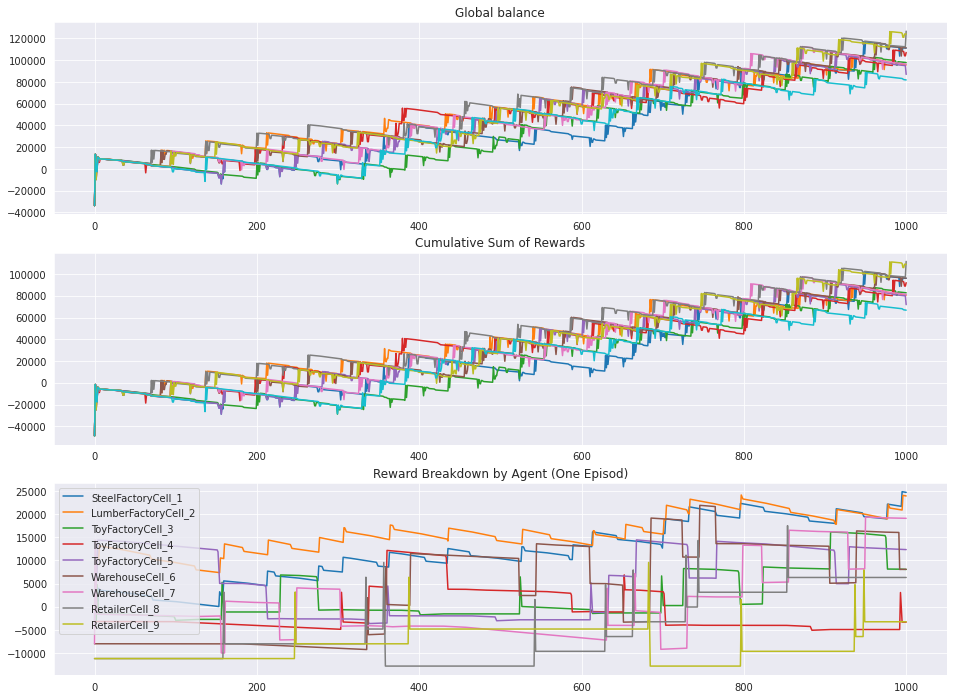

100%|██████████| 300/300 [02:24<00:00,  2.08it/s]


Rendering the animation...


<Figure size 1420x1712 with 0 Axes>

In [5]:
import world_of_supply_environment as ws
import world_of_supply_renderer as wsr
import world_of_supply_tools as wst
for module in [ws, wsr, wst]:
    importlib.reload(module)
        
# Measure the simulation rate, steps/sec
eposod_len = 1000
n_episods = 10
world = ws.WorldBuilder.create()
tracker = wst.SimulationTracker(eposod_len, n_episods, world.facilities.keys())
with tqdm(total=eposod_len * n_episods) as pbar:
    for i in range(n_episods):
        world = ws.WorldBuilder.create()
        policy = ws.SimpleControlPolicy()
        for t in range(eposod_len):
            outcome = world.act(policy.compute_control(world))
            tracker.add_sample(i, t, world.economy.global_balance().total(), 
                               {k: v.total() for k, v in outcome.facility_step_balance_sheets.items() } )
            pbar.update(1)        
tracker.render()
    
# Test rendering
renderer = wsr.AsciiWorldRenderer()
frame_seq = []
world = ws.WorldBuilder.create()
policy = ws.SimpleControlPolicy()
for epoch in tqdm(range(300)):
    frame = renderer.render(world)
    frame_seq.append(np.asarray(frame))
    world.act(policy.compute_control(world))

print('Rendering the animation...')
wsr.AsciiWorldRenderer.plot_sequence_images(frame_seq)

# Policy Training

In this section, we run RLlib policy trainers. These trainers evaluate the hand coded policy, learn a new policy from scrath, or learn a new policy by playing against the hand coded policy.

In [6]:
#!pip install ray
#import ray
!pip install -U ray
!ray install-nightly

!pip install tree
!pip install dm-tree

!pip install "ray==0.8.2"

import ray.rllib.models.tf.recurrent_tf_modelv2

  Using cached https://files.pythonhosted.org/packages/1a/3c/75913c91bd5a3411156628acb8be6437776a48608ff3d8d55b2f90ad8e43/ray-1.2.0-cp36-cp36m-manylinux2014_x86_64.whl
  Found existing installation: ray 0.8.2
    Uninstalling ray-0.8.2:
      Successfully uninstalled ray-0.8.2


Running: /usr/bin/python3 -m pip install -U https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-2.0.0.dev0-cp36-cp36m-manylinux2014_x86_64.whl.
  Using cached https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-2.0.0.dev0-cp36-cp36m-manylinux2014_x86_64.whl
  Found existing installation: ray 1.2.0
    Uninstalling ray-1.2.0:
      Successfully uninstalled ray-1.2.0
  Using cached https://files.pythonhosted.org/packages/a8/47/7bc688d2c06c1d0fbd388b4e2725028b2792e1f652a28b848462a724c972/ray-0.8.2-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: ray 2.0.0.dev0
    Uninstalling ray-2.0.0.dev0:
      Successfully uninstalled ray-2.0.0.dev0


In [8]:
!pip install 'ray[tune]'

     |████████████████████████████████| 317kB 4.1MB/s 


In [9]:
#from google.colab import files
#files.upload()

import world_of_supply_rllib_models as wsm
importlib.reload(wsm)
import world_of_supply_rllib as wsrl
importlib.reload(wsrl)
import world_of_supply_rllib_training as wsrt
importlib.reload(wsrt)


wsrt.print_model_summaries()

# Policy training
#trainer = wsrt.play_baseline(n_iterations = 1)
trainer = wsrt.train_ppo(n_iterations = 600)

2021-02-14 12:14:37,516	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2021-02-14 12:14:37,522	INFO resource_spec.py:212 -- Starting Ray with 7.47 GiB memory available for workers and up to 3.76 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-14 12:14:38,151	INFO services.py:1078 -- View the Ray dashboard at localhost:8265
2021-02-14 12:14:39,352	INFO catalog.py:292 -- Wrapping <class 'world_of_supply_rllib_models.FacilityNet'> as None
2021-02-14 12:14:42,344	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_SequenceMask_1/Max  [()]                 0           seq_in[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_SequenceMask_1/Maxi [()]                 0           tf_op_layer_SequenceMask_1/Max[0]
__________________________________________________________________________________________________
tf_op_layer_SequenceMask_1/Expa [(None, 1)]          0           seq_in[0][0]                     
____________________________________________________________________________________________

Exception: ignored

# Policy Evaluation

In this section, we evaluate the trained policy.

### Rendering One Episod for the Trained Policy

2021-02-14 13:06:45,790	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2021-02-14 13:06:45,793	INFO resource_spec.py:212 -- Starting Ray with 7.47 GiB memory available for workers and up to 3.76 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-14 13:06:46,424	INFO services.py:1078 -- View the Ray dashboard at localhost:8265
  0%|          | 0/500 [00:00<?, ?it/s]

Environment: Producer action space MultiDiscrete([8 6]), Consumer action space MultiDiscrete([3 3 6]), Observation space Box(0.0, 1.0, (56,), float64)


 47%|████▋     | 236/500 [00:03<00:01, 132.39it/s]2021-02-14 13:06:51,138	WARNING worker.py:1058 -- The dashboard on node 47fe91162466 failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1062, in create_server
    sock.bind(sa)
OSError: [Errno 99] Cannot assign requested address

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", line 920, in <module>
    dashboard.run()
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", line 368, in run
    aiohttp.web.run_app(self.app, host=self.host, port=self.port)
  File "/usr/local/lib/python3.6/dist-packages/aiohttp/web.py", line 508, in run_app
    loop.run_until_complete(main_task)
  File "/usr/lib/python3.6/asyncio/base_events.py", line 484, in run_until_complete
    return future.result()
  File "/usr/local/lib/python3

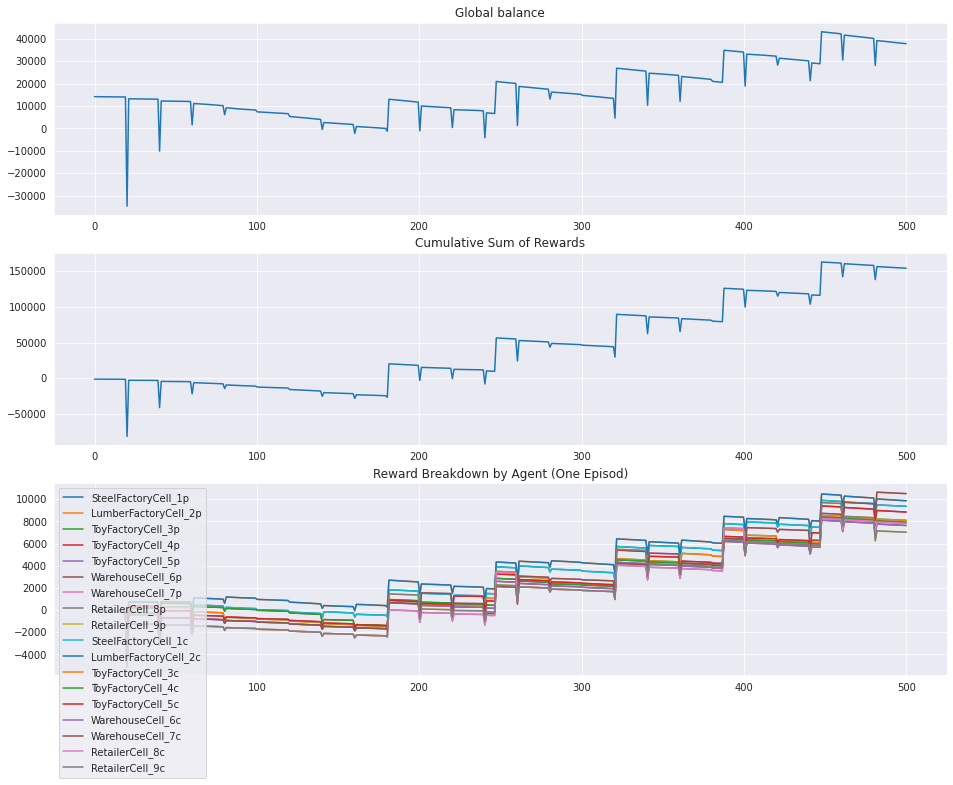

In [10]:
import world_of_supply_renderer as wsren
import world_of_supply_tools as wst
import world_of_supply_rllib as wsrl
import world_of_supply_rllib_training as wstr
for module in [wsren, wst, wsrl, wstr]:
    importlib.reload(module)

# Parameters of the tracing simulation
policy_mode = 'baseline'   # 'baseline' or 'trained'
episod_duration = 500
steps_to_render = None#(0, episod_duration)  # (0, episod_duration) or None

# Create the environment
renderer = wsren.AsciiWorldRenderer()
frame_seq = []
env_config_for_rendering = wstr.env_config.copy()
env_config_for_rendering.update({
    'downsampling_rate': 1
})
env = wsrl.WorldOfSupplyEnv(env_config_for_rendering)
env.set_iteration(1, 1)
print(f"Environment: Producer action space {env.action_space_producer}, Consumer action space {env.action_space_consumer}, Observation space {env.observation_space}")
states = env.reset()
infos = None
    
def load_policy(agent_id):
    if policy_mode == 'baseline':
        if wsrl.Utils.is_producer_agent(agent_id):
            return wsrl.ProducerSimplePolicy(env.observation_space, env.action_space_producer, wsrl.SimplePolicy.get_config_from_env(env))
        elif wsrl.Utils.is_consumer_agent(agent_id):
            return wsrl.ConsumerSimplePolicy(env.observation_space, env.action_space_consumer, wsrl.SimplePolicy.get_config_from_env(env))
        else:
            raise Exception(f'Unknown agent type {agent_id}')
    
    if policy_mode == 'trained':
        policy_map = wstr.policy_mapping_global.copy()
        wstr.update_policy_map(policy_map)   
        return trainer.get_policy(wstr.create_policy_mapping_fn(policy_map)(agent_id))

policies = {}
rnn_states = {}
for agent_id in states.keys():
    policies[agent_id] = load_policy(agent_id)
    rnn_states[agent_id] = policies[agent_id].get_initial_state()
    
# Simulation loop
tracker = wst.SimulationTracker(episod_duration, 1, env.agent_ids())
for epoch in tqdm(range(episod_duration)):
    
    action_dict = {}
    if epoch % wstr.env_config['downsampling_rate'] == 0:
        for agent_id, state in states.items():
            policy = policies[agent_id]
            rnn_state = rnn_states[agent_id]
            if infos is not None and agent_id in infos:
                action_dict[agent_id], rnn_state, _ = policy.compute_single_action( state, info=infos[agent_id], state=rnn_state ) 
            else:
                action_dict[agent_id], rnn_state, _ = policy.compute_single_action( state, state=rnn_state )   
   
    states, rewards, dones, infos = env.step(action_dict)
    tracker.add_sample(0, epoch, env.world.economy.global_balance().total(), rewards)
    
    if steps_to_render is not None and epoch >= steps_to_render[0] and epoch < steps_to_render[1]:
        frame = renderer.render(env.world)
        frame_seq.append(np.asarray(frame))
 
tracker.render()

if steps_to_render is not None:
    print('Rendering the animation...')
    wsren.AsciiWorldRenderer.plot_sequence_images(frame_seq)